In [2]:
import json,os, nltk,re
import numpy as np
from gensim.models import word2vec
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from scipy.spatial import distance
from sklearn.mixture import GMM

---
# Lab 8-10
### Looking into methods of textual entailment using the SNLI corpus
---

### Ideas
- Commonality of nouns between sentences
- Commonality of noun-verb phrases between sentences
- Edit-distance basis
- Lemmatisation

#### Methods
- Start with some simple methods (perceptron/NB)
- Maybe the sklearn text feature-extraction methods
- Logistic regression
- Could abuse the WER system for machine translation tasks to make a WE of s1-s2

### New ideas
- Lemmatisation or stemming
- Cross-bigrams
- word2vec difference between statements
- Use of the POS for clever stripping
- Use of POS for other reasons (?)

#### Import the data from the files in the snli data set

In [22]:
def import_file(s):
    x = []
    f_name = os.path.expanduser('~')+'/export/snli_1.0/snli_1.0_%s.jsonl' % s
    with open(f_name) as f:
        while f.readline()!='':
            x.append(json.loads(f.readline()))
    return np.array(x)

def build_vector(d,v, model=None, stage='train', stem=None):
    data = []
    for eg in d:
        tmp_in = extract_sent(eg, stem, model)
        data.append(tmp_in)
        
    if stage=='train':
        return v.fit_transform(data)
    else:
        return v.transform(data)

def extract_sent(eg, stem, model):
    sen1 = [x for x in re.findall('[\w-]+',eg['sentence1'].lower())]# if x not in stops]
    pos1 = POS_tags(eg, 'sentence1_parse')
    sen2 = [x for x in re.findall('[\w-]+',eg['sentence2'].lower())]# if x not in stops]
    pos2 = POS_tags(eg, 'sentence2_parse')
    tmp_in = {}
    if stem == 'stem':
        sen1 = stem_sent(sen1)
        sen2 = stem_sent(sen2)
    if stem == 'lemmatise':
        sen1 = lemmatise_sent(sen1, pos1)
        sen2 = lemmatise_sent(sen2, pos2)
    # Cross-unigrams
    for w1 in sen1:
        for w2 in sen2:
            try:
#                 if pos1[w1]==pos2[w2]:
#                     if 'NN' in pos1[w1] or 'VB' in pos1[w1]:
                val = 1.
                tmp_in[w1+'-'+w2] = val
            except KeyError:
                pass
#     Cross-bigrams
# #     sen1.insert(0,'<start>')
# #     sen2.insert(0,'<start>')
#     sen1.append('<end>')
#     sen2.append('<end>')
#     for idx,w1 in enumerate(sen1):
#         for idx,w2 in enumerate(sen2):
#             try:
# #                 if pos1[w1]==pos2[w2]:
# #                     if 'NN' in pos1[w1] or 'VB' in pos1[w1]:
#                     val = 1.
#                     bg1 = sen1[idx]+'_'+sen1[idx+1]
#                     bg2 = sen2[idx]+'_'+sen2[idx+1]
#                     tmp_in[bg1+'-'+bg2] = val
#             except:
                pass
#     Cosine distance
#     tmp_in['cosine'] = calculate_cos(eg,model)
    return tmp_in
    
def build_w2v_vector(d, model, stem=None):
    data = []
    for eg in d:
        tmp_in = extract_word2vec(eg, model)
        data.append(tmp_in)
    return np.vstack(data)
    
def extract_word2vec(eg,model):
    model_length = 300
    sen1 = [x for x in re.findall('[\w-]+',eg['sentence1'].lower())]# if x not in stops]
    pos1 = POS_tags(eg, 'sentence1_parse')
    sen2 = [x for x in re.findall('[\w-]+',eg['sentence2'].lower())]# if x not in stops]
    pos2 = POS_tags(eg, 'sentence2_parse')
    w2v1 = np.ones((len(sen1),300))
    for idx,x in enumerate(sen1):
        if x in model:
            w2v1[idx,:] = model[x]
    w2v2 = np.ones((len(sen2),300))
    for idx,x in enumerate(sen2):
        if x in model:
            w2v2[idx,:] = model[x]
#     Unneeded now
#     if w2v1.shape[1] != 300:
#         w2v1 = np.zeros(300)
#     if w2v2.shape[1] != 300:
#         w2v2 = np.zeros((2,300))
    if w2v1.shape[0] < 2:
        w2v1 = np.append(w2v1,np.ones((1,300)),axis=0)
    if w2v2.shape[0] < 2:
        w2v2 = np.append(w2v2,np.ones((1,300)),axis=0)
    w2vGMM1 = GMM(n_components=1, n_iter=10)
    w2vGMM1.fit(w2v1)
    
    return w2vGMM1.predict_proba(w2v2)

def calculate_cos(eg,model):
    sen_vec1 = np.zeros((300))
    sen_vec2 = np.zeros((300))
    sen1 = [x for x in re.findall('[\w-]+',eg['sentence1'].lower())]# if x not in stops]
    pos1 = POS_tags(eg, 'sentence1_parse')
    sen2 = [x for x in re.findall('[\w-]+',eg['sentence2'].lower())]# if x not in stops]
    pos2 = POS_tags(eg, 'sentence2_parse')
    for x in sen1:
        if x in model:
            sen_vec1 += model[x]
    for x in sen2:
        if x in model:
            sen_vec2 += model[x]
    cos_d = distance.cosine(sen_vec1,sen_vec2)
    if np.isnan(cos_d):
        return 0.
    else:
        return cos_d
            
def make_lbls(d):
    return np.array([eg['gold_label'] for eg in d])

def lemmatise_sent(sent, pos):
    s = []
    for x in sent:
        try:
            s.append(lemmatizer.lemmatize(x, pos[x]))
        except:
            s.append(lemmatizer.lemmatize(x))
    return s

def stem_sent(sent):
    s = [stemmer.stem(x) for x in sent]
    return s

def POS_tags(eg, parse):
    prs = re.compile('\(([\w$]*) ([\w-]*)\)')
    tags = re.findall(prs,eg[parse])
    return dict((y.lower(),x) for (x,y) in tags)

def rename_pos(tag):
    return tag[0].lower()

In [4]:
# sim = {'VB':list(),'NN':list()}
# model.similarity('person','person')

In [5]:
print train_set[4]['sentence1']
print train_set[4]['sentence2']
print train_set[4]['gold_label']

print
print POS_tags(train_set[4],'sentence1_parse')
print POS_tags(train_set[4],'sentence2_parse')
print
print extract_sent(train_set[4],None,model)
# for i in range(len(train_set)):
#     x = calculate_cos(train_set[i], model)
#     if np.isnan(x):
#         print x, i, train_set[i]['sentence1'], train_set[i]['sentence2']

NameError: name 'train_set' is not defined

In [26]:
train_set = import_file('train')
dev_set = import_file('test') # 'test' for evaluation, 'dev' for development

In [6]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

### Build a sparse vector representation of the cross unigrams

- Make the sparse vector the same way as lab 2.
- Then add the intersection of tokens between sen1 and sen2 as opposed to just the counts.

Look into scipy.sparse : may need it for a dataset of this size.
That or we

In [9]:
model = word2vec.Word2Vec.load_word2vec_format('/Users/harry/export/GoogleNews-vectors-negative300.bin', binary=True)

In [27]:
v=DictVectorizer()

X = build_vector(train_set, v, model=model)
# X = build_w2v_vector(train_set,model)
print 'train vectors built'
dev_X = build_vector(dev_set, v, stage='test', model=model)
# dev_X = build_w2v_vector(dev_set,model)
print 'test vectors built'
X_lbls = make_lbls(train_set)
dev_lbls = make_lbls(dev_set)
print 'labels built'
print 'Vector shape: ', X.shape

train vectors built
test vectors built
labels built
Vector shape:  (275076, 2739148)


In [28]:
clf = Perceptron(n_jobs=-1)
traPer = clf.fit(X, X_lbls)

In [29]:
print 'Accuracy:', traPer.score(dev_X,dev_lbls)
print '____________________________________________________'
print ''
print 'Precision, recall and F-score for baseline'
print ''
print classification_report(traPer.predict(dev_X),dev_lbls)
print '____________________________________________________'
print ''
print 'Confusion Matrix'
print ''
print confusion_matrix(traPer.predict(dev_X),dev_lbls)

Accuracy: 0.6636
____________________________________________________

Precision, recall and F-score for baseline

             precision    recall  f1-score   support

          -       0.00      0.00      0.00        15
contradiction       0.75      0.67      0.71      1782
 entailment       0.63      0.69      0.66      1483
    neutral       0.65      0.63      0.64      1720

avg / total       0.68      0.66      0.67      5000

____________________________________________________

Confusion Matrix

[[   0    4    3    8]
 [  18 1202  245  317]
 [  28  166 1028  261]
 [  28  239  365 1088]]


In [17]:
mst_sig_feats = [np.argsort(clf.coef_)[x,:-11:-1] for x in range(clf.coef_.shape[0])]
for idx,x in enumerate(mst_sig_feats):
    print '________________________________'
    print ['-','contradictment','entailment','neutral'][idx]
    print ''
    print np.vstack((v.feature_names_[ft],clf.coef_[idx,ft]) for ft in x)

________________________________
-

[[u'people-outside' u'6.0']
 [u'and-his' u'6.0']
 [u'uniform-in' u'5.0']
 [u'holding-wearing' u'5.0']
 [u'pants-woman' u'5.0']
 [u'painting-man' u'5.0']
 [u'sit-men' u'5.0']
 [u'girl-has' u'5.0']
 [u'stands-are' u'5.0']
 [u'horse-a' u'5.0']]
________________________________
contradictment

[[u'cosine' u'56.9430113033']
 [u'room-outside' u'49.0']
 [u'girls-boys' u'47.0']
 [u'a_man-a_woman' u'47.0']
 [u'men-women' u'46.0']
 [u'sitting-standing' u'45.0']
 [u'outside-inside' u'45.0']
 [u'boys-girls' u'41.0']
 [u'young-old' u'41.0']
 [u'a-nothing' u'40.0']]
________________________________
entailment

[[u'red-red' u'61.0']
 [u'park-park' u'59.0']
 [u'blue-blue' u'58.0']
 [u'black-black' u'51.0']
 [u'white-white' u'48.0']
 [u'yellow-yellow' u'45.0']
 [u'green-green' u'44.0']
 [u'bus-bus' u'43.0']
 [u'beach-beach' u'41.0']
 [u'pink-pink' u'40.0']]
________________________________
neutral

[[u'a-joyously' u'45.0']
 [u'in_a-is_a' u'36.0']
 [u'a-professional' 

In [244]:
print np.sum(X_lbls=='contradiction')
print np.sum(X_lbls=='neutral')
print np.sum(X_lbls=='entailment')
print np.sum(X_lbls=='-')
recorded_accs = []
recorded_lbls = []

91788
91588
91303
397


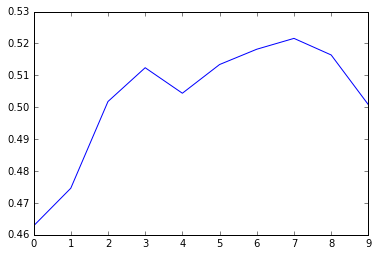

In [48]:
import matplotlib.pyplot as plt
acc_ls = []
task = 'Cross-unigrams'
len_train_set = len(train_set)
for i in range(1,11):
    clf = Perceptron(n_jobs=-1)
    traPer = clf.fit(X[:int(len_train_set * (i*0.1))], X_lbls[:int(len_train_set * (i*0.1))])
    acc_ls.append(traPer.score(dev_X,dev_lbls))
%matplotlib inline
plt.plot(acc_ls)

recorded_accs.append(acc_ls)
recorded_lbls.append(task)

In [42]:
model.similarity('red','red')

1.0000000000000002

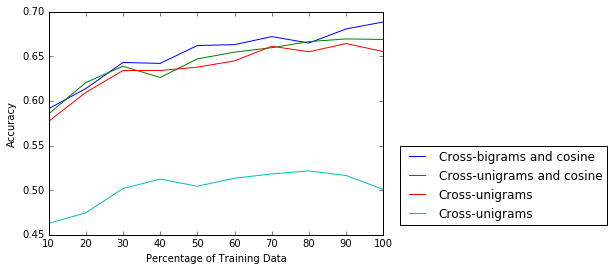

In [51]:
plt.plot(range(10,101,10),np.array(recorded_accs).T)
plt.xlabel('Percentage of Training Data')
plt.ylabel('Accuracy')
plt.legend(recorded_lbls, bbox_to_anchor=(1.05, 0.4), loc=2, borderaxespad=0.)